In [ ]:
%matplotlib inline

In [ ]:
from gym.spaces.box import Box
from gym.spaces.discrete import Discrete
import numpy as np

class hitorstandcontinuous:
    def __init__(self):
        self.observation_space = Box(0*np.ones(1), 1.0*np.ones(1), dtype=np.float64)
        self.action_space = Discrete(2)
        self.num_envs = 1
        self.cnt = 0
        self.length = 50

    def step(self, action):
        self.cnt += 1
        #if action == 1:
        #    if self.state > 0.5:
        #        self.state = np.random.uniform(0.0, self.state, (1,))
        #    else:
        #        self.state = np.random.uniform(self.state, 1.0, (1,))
        #reward = 0.0
        if action == 1:
            next__state = min(self.state + np.random.uniform(0.0, 0.25, (1,)), np.array([1.0])) 
            reward =  float(next__state//0.05 - self.state//0.05)
            self.state = next__state
            
        elif action == 0:
            self.state = max(self.state - np.random.uniform(0.0, 0.25, (1,)), np.array([0.0]))
            reward = 0
        if self.state == np.array([1.0]):
          done = np.array([True])
        else:
          done = np.array([self.cnt == self.length])
        #reward = float(0.5 - np.abs(self.state-0.5))
        if done:
            self.cnt = 0
        #    reward = float(self.state)
        return self.state, reward, done, None

    def reset(self):
        self.cnt = 0
        self.state  = np.array([0.5])
        #self.state = np.random.uniform(0.0, 1.0, (1,))
        return self.state

    def render(self):
        raise NotImplementedError

    def seed(self, seed_value):
        np.random.seed(seed)
        print('numpy seed is changed to {} globally'.format(seed))

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


env = hitorstandcontinuous()
m = env.action_space.n

seed = 3
np.random.seed(seed)
torch.manual_seed(seed)


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = "cpu"

In [ ]:
import bisect
import numpy as np

def kk(x, y):
    return np.exp(-abs(x-y))

def rho(x, y):
    return np.exp(abs(x-y)) - np.exp(-abs(x-y))

class noisebuffer:
    def __init__(self, m, sigma):
        self.buffer = []
        self.base = {}
        self.m = m
        self.sigma = sigma

    def sample(self, s):
        buffer = self.buffer
        sigma = self.sigma
            
        if len(buffer) == 0:
            v0 = np.random.normal(0, sigma)
            v1 = np.random.normal(0, sigma)
            self.buffer.append((s, v0, v1))
            return (v0, v1)
        else:
            idx = bisect.bisect(buffer, (s, 0, 0))
            if len(buffer) == 1:
                if buffer[0][0] == s:
                    return (buffer[0][1], buffer[0][2])
            else:
                if (idx <= len(buffer)-1) and (buffer[idx][0] == s):
                    return (buffer[idx][1], buffer[idx][2])
                elif (idx >= 1) and (buffer[idx-1][0] == s):
                    return (buffer[idx-1][1], buffer[idx-1][2])
                elif (idx <= len(buffer)-2) and (buffer[idx+1][0] == s):
                    return (buffer[idx+1][1], buffer[idx+1][2])
            
        if s < buffer[0][0]:
            mean0 = kk(s, buffer[0][0]) * buffer[0][1]
            mean1 = kk(s, buffer[0][0]) * buffer[0][2]
            var0 = 1 - kk(s, buffer[0][0]) ** 2
            var1 = 1 - kk(s, buffer[0][0]) ** 2
            v0 = np.random.normal(mean0, np.sqrt(var0) * sigma)
            v1 = np.random.normal(mean1, np.sqrt(var1) * sigma)
            self.buffer.insert(0, (s, v0, v1))
        elif s > buffer[-1][0]:
            mean0 = kk(s, buffer[-1][0]) * buffer[0][1]
            mean1 = kk(s, buffer[-1][0]) * buffer[0][2]
            var0 = 1 - kk(s, buffer[-1][0]) ** 2
            var1 = var0
            v0 = np.random.normal(mean0, np.sqrt(var0) * sigma)
            v1 = np.random.normal(mean1, np.sqrt(var1) * sigma)
            self.buffer.insert(len(buffer), (s, v0, v1))
        else:
            idx = bisect.bisect(buffer, (s, None, None))
            sminus, eminus0, eminus1 = buffer[idx-1]
            splus, eplus0, eplus1 = buffer[idx]
            mean0 = (rho(splus, s)*eminus0 + rho(sminus, s)*eplus0) / rho(sminus, splus)
            mean1 = (rho(splus, s)*eminus1 + rho(sminus, s)*eplus1) / rho(sminus, splus)
            var0 = 1 - (kk(sminus, s)*rho(splus, s) + kk(splus, s)*rho(sminus, s)) / rho(sminus, splus)
            var1 = var0
            v0 = np.random.normal(mean0, np.sqrt(var0) * sigma)
            v1 = np.random.normal(mean1, np.sqrt(var1) * sigma)
            self.buffer.insert(idx, (s, v0, v1))
        return (v0, v1)

    def reset(self):
        self.buffer = []

In [ ]:
'''
nb = noisebuffer(2, 1.)
print(nb.sample(0.5))
print(nb.sample(0.3))
print(nb.sample(0.7))
print(nb.sample(0.4))
print(nb.sample(0.5))
print(nb.sample(0.7))
'''

'\nnb = noisebuffer(2, 1.)\nprint(nb.sample(0.5))\nprint(nb.sample(0.3))\nprint(nb.sample(0.7))\nprint(nb.sample(0.4))\nprint(nb.sample(0.5))\nprint(nb.sample(0.7))\n'

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):

    def __init__(self, hidden=16):
        super(DQN, self).__init__()
        self.linear1 = nn.Linear(1, hidden)
        self.linear2 = nn.Linear(hidden, hidden)
        self.head = nn.Linear(hidden, m)
        self.nb = noisebuffer(2, 0.4)


    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, s):
        x = F.relu(self.linear1(s))
        x = F.relu(self.linear2(x))
        x = self.head(x)
        eps = [self.nb.sample(float(state)) for state in s]
        eps = torch.Tensor(eps)
        return x + eps

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest value for column of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(m)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    #import pdb; pdb.set_trace()
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [ ]:
num_episodes = 100
episodic_rewards = []
for i_episode in range(num_episodes):
    if i_episode % 10 == 0:
        print(i_episode)
    # Initialize the environment and state
    state = torch.Tensor(env.reset()).unsqueeze(0)
    total_reward = 0
    for t in count():
        # Select and perform an action
        action = select_action(state)
        next_state, reward, done, info = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        if not done:
            next_state = torch.Tensor(next_state).unsqueeze(0)
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        #import pdb; pdb.set_trace()
        total_reward += float(reward.squeeze(0).data)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            #plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    episodic_rewards.append(total_reward)
    #policy_net.nb.reset()
    #target_net.nb.reset()

print('Complete')
plt.ioff()
plt.show()

0
10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


20
30
40
50
60
70
80
90
Complete


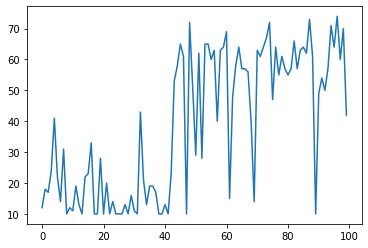

In [ ]:
plt.plot(episodic_rewards)
plt.show()

In [ ]:
state = torch.Tensor(env.reset()).unsqueeze(0)
policy_net(state)

tensor([[12.4044, 13.2997]], grad_fn=<AddBackward0>)

In [ ]:
print(episodic_rewards)
with open('dpql.txt', 'a') as fw:
    for rr in episodic_rewards:
        fw.write(str(rr))
        fw.write(' ')
    fw.write('\n')

[12.0, 18.0, 17.0, 24.0, 41.0, 22.0, 14.0, 31.0, 10.0, 12.0, 11.0, 19.0, 13.0, 10.0, 22.0, 23.0, 33.0, 10.0, 10.0, 28.0, 10.0, 20.0, 10.0, 14.0, 10.0, 10.0, 10.0, 13.0, 10.0, 16.0, 11.0, 10.0, 43.0, 21.0, 13.0, 19.0, 19.0, 17.0, 10.0, 10.0, 13.0, 10.0, 23.0, 53.0, 58.0, 65.0, 61.0, 10.0, 72.0, 51.0, 29.0, 62.0, 28.0, 65.0, 65.0, 60.0, 63.0, 40.0, 63.0, 64.0, 69.0, 15.0, 48.0, 58.0, 64.0, 57.0, 57.0, 56.0, 40.0, 14.0, 63.0, 61.0, 64.0, 67.0, 72.0, 47.0, 64.0, 55.0, 61.0, 57.0, 55.0, 57.0, 66.0, 57.0, 63.0, 64.0, 62.0, 73.0, 61.0, 10.0, 49.0, 54.0, 50.0, 57.0, 71.0, 64.0, 74.0, 60.0, 70.0, 42.0]
